In [1]:
%matplotlib widget
import torch
import warnings
import os
import copy
import subprocess
import shlex
import matplotlib.pyplot as plt
from tqdm import TqdmExperimentalWarning
warnings.filterwarnings("ignore", category=TqdmExperimentalWarning)
from tqdm.autonotebook import tqdm
from torch.profiler import profile,  ProfilerActivity

os.environ['TORCH_CUDA_ARCH_LIST'] = f'{torch.cuda.get_device_properties(0).major}.{torch.cuda.get_device_properties(0).minor}'

from sphMath.sampling import buildDomainDescription, sampleDivergenceFreeNoise
from sphMath.modules.adaptiveSmoothingASPH import n_h_to_nH
from sphMath.plotting import visualizeParticles, updatePlot
from sphMath.integration import getIntegrator
from sphMath.util import volumeToSupport
from sphMath.boundary import sampleDomainSDF
from sphMath.kernels import Kernel_Scale
from sphMath.sdf import getSDF, sdfFunctions, operatorDict, sampleSDF
from sphMath.regions import buildRegion, filterRegion, plotRegions
from sphMath.modules.timestep import computeTimestep
from sphMath.schemes.initializers import initializeSimulation, updateBodyParticles
from sphMath.schemes.deltaSPH import deltaPlusSPHScheme, DeltaPlusSPHSystem
from sphMath.schema import getSimulationScheme
from sphMath.enums import *
import math

In [218]:
device = torch.device('cuda:0') if torch.cuda.is_available() else torch.device('cpu')
dtype = torch.float32

nx = 128
L = 2
dim = 2
targetNeighbors = n_h_to_nH(4, dim)
dx = L / nx
area = volumeToSupport(dx**dim, targetNeighbors, dim)
domain = buildDomainDescription(l = L, dim = dim, periodic = True, device = device, dtype = dtype)


kernel = KernelType.Wendland4
integrationScheme = IntegrationSchemeType.symplecticEuler
integrator = getIntegrator(integrationScheme)


freeSurface = False
scheme = SimulationScheme.DeltaSPH
simulator, SimulationSystem, config, integrator = getSimulationScheme(
     scheme, kernel, integrationScheme, 
     1.0, targetNeighbors, domain)

config['particle'] = {
    'nx': nx,
    'dx': L/nx,
    'targetNeighbors': targetNeighbors,
    'band': 0
}
config['fluid'] = {
    'rho0': 1,
    'c_s': 10
}
config['surfaceDetection']['active'] = freeSurface
config['shifting']['freeSurface'] = freeSurface

In [219]:
fluid_sdf = lambda x: sampleDomainSDF(x, domain, invert = True)

regions = []
regions.append(buildRegion(sdf = fluid_sdf, config = config, type = 'fluid'))

for region in regions:
    region = filterRegion(region, regions)

True: dxs: [tensor(0.0156, device='cuda:0'), tensor(0.0156, device='cuda:0')], ns: [tensor(128, device='cuda:0', dtype=torch.int32), tensor(128, device='cuda:0', dtype=torch.int32)], nx: 128


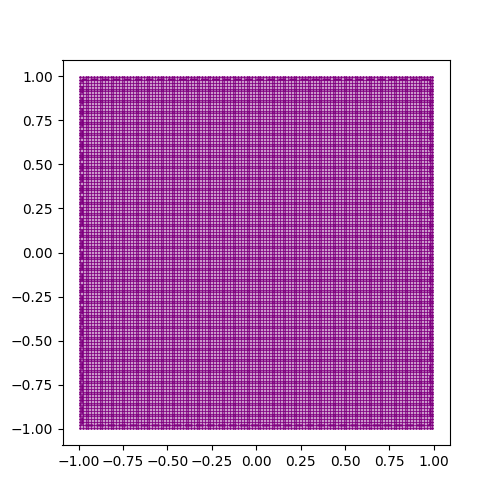

In [220]:
fig, axis = plt.subplots(1, 1, figsize=(5, 5), squeeze=False)
    
plotRegions(regions, axis[0,0], plotFluid = True, plotParticles = True)


In [221]:
particleState, config, rigidBodies = initializeSimulation(scheme, config, regions)
particles = copy.deepcopy(particleState)

particles.positions += torch.randn_like(particles.positions) * particles.supports.view(-1,1) * 0.05

In [222]:
from sphMath.neighborhood import evaluateNeighborhood, filterNeighborhoodByKind, coo_to_csr, SupportScheme

neighborhood = None
neighborhood, neighbors = evaluateNeighborhood(particles, domain, kernel, verletScale = config['neighborhood']['verletScale'], mode = SupportScheme.SuperSymmetric, priorNeighborhood=neighborhood)
particles.numNeighbors = coo_to_csr(filterNeighborhoodByKind(particles, neighbors.neighbors, which = 'noghost')).rowEntries


In [223]:
from sphMath.modules.density import computeDensity

rho = computeDensity(particles, kernel, neighbors.get('noghost'), SupportScheme.SuperSymmetric, config)

In [224]:
def periodicPositions(positions, domain):    
    minD = domain.min
    maxD = domain.max
    periodicity = domain.periodic

    pos = [(torch.remainder(positions[:, i] - minD[i], maxD[i] - minD[i]) + minD[i]) if periodicity[i] else positions[:,i] for i in range(domain.dim)]
    modPos = torch.stack(pos, dim = -1)
    return modPos

In [225]:
periodic_positions = periodicPositions(particles.positions, domain)
numPoints = periodic_positions.shape[0]

offests = [-1,0,1]

tiled_positions = []
for i in range(len(offests)):
    for j in range(len(offests)):
        tiled_positions.append(periodic_positions + torch.tensor([offests[i], offests[j]], device=device, dtype=dtype) * torch.tensor([L, L], device=device, dtype=dtype))
tiled_positions = torch.cat(tiled_positions, dim = 0)

In [226]:
from scipy.spatial import Voronoi

vor = Voronoi(tiled_positions.cpu().numpy())

point_regions = vor.point_region[numPoints*4:numPoints*5]
voronoiAreas = []
for i in tqdm(range(len(point_regions))):
    region_i = point_regions[i]
    vertices = []
    for j in range(len(vor.regions[region_i])):
        vertex = torch.tensor(vor.vertices[vor.regions[region_i][j]])
        vertices.append(vertex)
    center_point = torch.mean(torch.stack(vertices), dim = 0)

    triangleAreas = []
    for j in range(len(vertices)):
        t0 = center_point
        t1 = vertices[j]
        t2 = vertices[(j + 1) % len(vertices)]
        a = torch.linalg.norm(t1 - t0)
        b = torch.linalg.norm(t2 - t1)
        c = torch.linalg.norm(t0 - t2)
        s = (a + b + c) / 2
        area = torch.sqrt(s * (s - a) * (s - b) * (s - c))
        triangleAreas.append(area)
    triangleAreas = torch.tensor(triangleAreas)
    area = torch.sum(triangleAreas)

    # print(triangleAreas)
    voronoiAreas.append(area)


    # break
voronoiAreas = torch.tensor(voronoiAreas, device=device, dtype=dtype)

  0%|          | 0/16384 [00:00<?, ?it/s]

In [227]:
voronoiSupports = volumeToSupport(voronoiAreas, targetNeighbors, dim)

particles.masses = voronoiAreas * config['fluid']['rho0']
particles.supports = voronoiSupports


neighborhood, neighbors = evaluateNeighborhood(particles, domain, kernel, verletScale = config['neighborhood']['verletScale'], mode = SupportScheme.SuperSymmetric, priorNeighborhood=None)
particles.numNeighbors = coo_to_csr(filterNeighborhoodByKind(particles, neighbors.neighbors, which = 'noghost')).rowEntries


In [228]:
rho = computeDensity(particles, kernel, neighbors.get('noghost'), SupportScheme.Gather, config)

print(rho.min(), rho.max())

tensor(0.9551, device='cuda:0') tensor(1.4353, device='cuda:0')


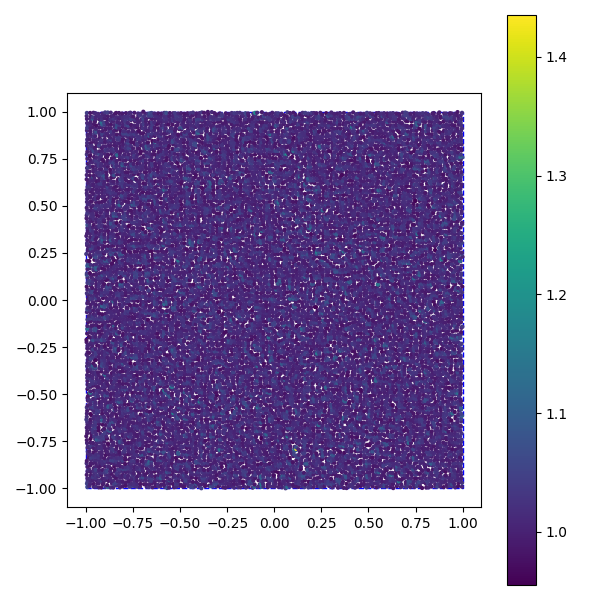

In [229]:

fig, axis = plt.subplots(1, 1, figsize=(6, 6), squeeze=False)

plotState = visualizeParticles(fig, axis[0,0], particles, domain, rho, kernel)

fig.tight_layout()

In [230]:
from ml import *

In [231]:
from sphMath.sphOperations.shared import scatter_sum

class ScatterSumLayer(nn.Module):
    def __init__(self):
        super(ScatterSumLayer, self).__init__()
    def forward(self, input, index, dim, dim_size):
        return scatter_sum(input, index, dim=dim, dim_size=dim_size)
    
def runMLP_(mlp : torch.nn.Module, features : torch.Tensor, batches : int, verbose : bool = False):  
    if verbose:
        print(f'MLP {features.shape} -> {mlp[-1].out_features} features')
    transposedFeatures = features.view(batches,-1, *features.shape[1:])
    
    processedFeatures = mlp(transposedFeatures)
    processedFeatures = processedFeatures.view(-1, *processedFeatures.shape[2:])
    if verbose:
        print(f'\tFeatures: {processedFeatures.shape} [min: {torch.min(processedFeatures)}, max: {torch.max(processedFeatures)}, mean: {torch.mean(processedFeatures)}]')
    return processedFeatures


In [232]:
class SimpleGNN(torch.nn.Module):
    def __init__(self, hyperParameterDict):
        super(SimpleGNN, self).__init__()
            
        self.edgeMLP1 = buildMLPwDict({
            'layout': [hyperParameterDict['hiddenUnits']] * hyperParameterDict['hiddenLayers'],
            'inputFeatures': hyperParameterDict['edgeFeatures'] + hyperParameterDict['coordinateFeatures'],
            'output': hyperParameterDict['nodeFeatures'],
            'preNorm': False,
            'norm': False,
            # 'channels': [1],
            'activation': hyperParameterDict['activation'],
        })
        self.vertexMLP = buildMLPwDict({
            'layout': [hyperParameterDict['hiddenUnits']] * hyperParameterDict['hiddenLayers'],
            'inputFeatures': hyperParameterDict['nodeFeatures'],
            'output': hyperParameterDict['nodeFeatures'],
            'preNorm': True,
            'norm': False,
            'channels': [1],
            'activation': hyperParameterDict['activation'],
        })
        self.activationLayer = getActivationLayer(hyperParameterDict['activation'])
        self.ScatterSumLayer = ScatterSumLayer()
        self.edgeMLP2 = buildMLPwDict({
            'layout': [hyperParameterDict['hiddenUnits']] * hyperParameterDict['hiddenLayers'],
            'inputFeatures': hyperParameterDict['nodeFeatures'] + hyperParameterDict['edgeFeatures']//2,
            'output': 1,
            'preNorm': False,
            'norm': False,
            'activation': hyperParameterDict['activation'],
        })
        self.hyperParameterDict = hyperParameterDict

    def forward(self, particles, neighbors):
        i, j = neighbors.get('noghost')[0].row, neighbors.get('noghost')[0].col
        encodedDistances = basisEncoderLayer(
            neighbors.get('noghost')[1].x_ij,
            self.hyperParameterDict['basisTerms'], 
            self.hyperParameterDict['basis'],
            self.hyperParameterDict['encoderMode']
        )
        hij = (particles.supports[i] + particles.supports[j]) / 2
        edge_features = torch.cat([
            encodedDistances / hij.view(-1, 1),
            particles.masses[i].view(-1, 1),
            particles.masses[j].view(-1, 1),
            particles.supports[i].view(-1, 1),
            particles.supports[j].view(-1, 1),
        ], dim = -1)

        processedEdges = runMLP_(self.edgeMLP1, edge_features,1, verbose = False)
        aggregatedEdges = scatter_sum(processedEdges, i, dim = 0, dim_size = particles.positions.shape[0])
        vertexFeatures = runMLP_(self.vertexMLP, aggregatedEdges, 1, verbose = False)
        vertexFeatures = self.activationLayer(vertexFeatures)
        newFeatures = torch.cat([
            vertexFeatures,
            particles.masses.view(-1, 1),
            particles.supports.view(-1, 1),
        ], dim = -1)
        processedEdges2j = runMLP_(self.edgeMLP2, newFeatures[j], 1, verbose = False)[:,0]
        processedEdges2i = runMLP_(self.edgeMLP2, newFeatures[i], 1, verbose = False)[:,0]
        processedEdges2 = (processedEdges2i + processedEdges2j) / 2
        return processedEdges2


In [233]:

basisTerms = 8
hiddenLayers = 2
hiddenUnits = 128
nodeFeatures = 8
activation = 'relu'

additionalEdgeFeatures = 4 # v_i, v_j, h_i, h_j

neighbors.get('noghost')[1].x_ij

encodedDistances = basisEncoderLayer(
    neighbors.get('noghost')[1].x_ij,
    basisTerms, 
    'ffourier',
    'cat'
)
GNN = SimpleGNN({
    'hiddenLayers': hiddenLayers,
    'hiddenUnits': hiddenUnits,
    'edgeFeatures': additionalEdgeFeatures,
    'coordinateFeatures': encodedDistances.shape[1],
    'nodeFeatures': nodeFeatures,
    'activation': activation,
    'basisTerms': basisTerms,
    'basis': 'ffourier',
    'encoderMode': 'cat',
}).to(device)


optimizer = torch.optim.Adam(GNN.parameters(), lr=1e-4)
learningRateScheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=2500, gamma=0.5)

In [234]:
trainIterations = 2**16
losses = []
predictions = []

for i in (t := tqdm(range(trainIterations))):
    optimizer.zero_grad()
    W_nn = GNN(particles, neighbors)

    i, j = neighbors.get('noghost')[0].row, neighbors.get('noghost')[0].col
    rho_nn = scatter_sum(W_nn, i, dim = 0, dim_size = particles.positions.shape[0])

    error = rho_nn - 1
    loss = torch.sum(error**2)
    # print(f'Loss: {loss.item()}')

    loss.backward()
    optimizer.step()
    losses.append(loss.item())
    predictions.append(rho_nn.detach().cpu().numpy())
    t.set_postfix(loss=loss.item(), lr = learningRateScheduler.get_last_lr()[0])
    learningRateScheduler.step()

  0%|          | 0/65536 [00:00<?, ?it/s]

KeyboardInterrupt: 

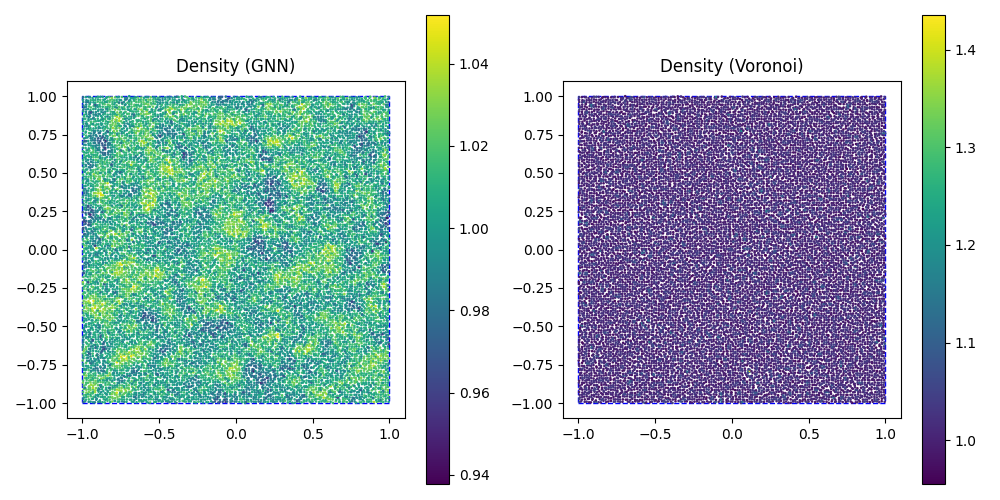

In [241]:

fig, axis = plt.subplots(1, 2, figsize=(10, 5), squeeze=False)

plotState = visualizeParticles(fig, axis[0,0], particles, domain, rho_nn, kernel, markerSize = 0.75)
axis[0,0].set_title('Density (GNN)')
plotState = visualizeParticles(fig, axis[0,1], particles, domain, rho, kernel, markerSize = 0.75)
axis[0,1].set_title('Density (Voronoi)')

fig.tight_layout()

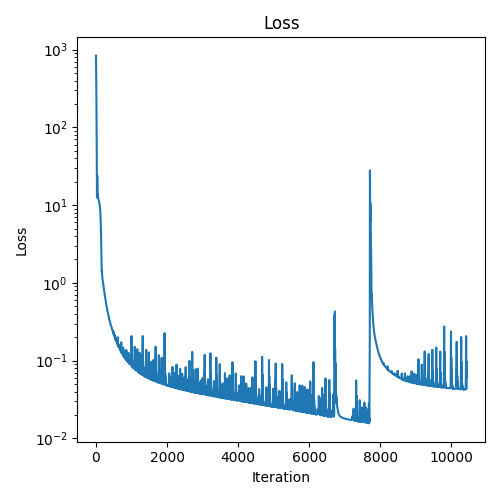

In [211]:
fig, axis = plt.subplots(1, 1, figsize=(5, 5), squeeze=False)
axis[0,0].plot(losses)
axis[0,0].set_title('Loss')
axis[0,0].set_xlabel('Iteration')
axis[0,0].set_ylabel('Loss')
axis[0,0].set_yscale('log')
fig.tight_layout()